# Project Milestone 5:

### Merging the Data and Storing in a Database/Visualizing Data
Now that you have cleaned and transformed your 3 datasets, you need to load them into a database. You can choose what kind of database (SQLLite or MySQL, Postgre SQL are all free options). You will want to load each dataset into SQL Lite as an individual table and then you must join the datasets together in Python into 1 dataset.

Once all the data is merged together in your database, create 5 visualizations that demonstrate the data you have cleansed. You should have at least 2 visualizations that have data from more than one source (meaning, if you have 3 tables, you must have visualizations that span across 2 of the tables – you are also welcome to use your consolidated dataset that you created in the previous step, if you do that, you have met this requirement).

For the visualization portion of the project, you are welcome to use a python library like Matplotlib, Seaborn, or an R package ggPlot2, Plotly, or Tableau/PowerBI.

Clearly label each visualization. Submit your code for merging and storing in the database, with your code for the visualizations along with a 250-500-word summary of what you learned and had to do to complete the project. In your write-up, make sure to address the ethical implications of cleansing data and your project topic. 

In [1]:
# Load necessary libraries
import sqlite3
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
from fuzzywuzzy import process
import warnings

# Ignore all warnings
warnings.filterwarnings('ignore')

In [2]:
# Load the three CSV files into DataFrames
flat_file_df = pd.read_csv('C:/Users/aliss/OneDrive - Bellevue University/DSC540/Cleaned_EdStatsData.csv')
website_df = pd.read_csv('C:/Users/aliss/OneDrive - Bellevue University/DSC540/Cleaned_WebsiteData.csv')
api_df = pd.read_csv('C:/Users/aliss/OneDrive - Bellevue University/DSC540/Cleaned_APIData.csv')

# Create a SQLite connection
conn = sqlite3.connect('DSC540Project.db')

# Load each DataFrame into a separate table
flat_file_df.to_sql(name='table_flat_file_df', con=conn, index=False, if_exists='replace')
website_df.to_sql(name='table_website_df', con=conn, index=False, if_exists='replace')
api_df.to_sql(name='table_api_df', con=conn, index=False, if_exists='replace')

66

In [3]:
%load_ext sql
%sql sqlite:///DSC540Project.db

In [4]:
%sql SELECT * FROM table_flat_file_df LIMIT 5;

 * sqlite:///DSC540Project.db
Done.


Country,Rate,Year
Arab World,77%,2014
East Asia & Pacific,95%,2014
East Asia & Pacific (excluding high income),95%,2014
Europe & Central Asia,99%,2014
Europe & Central Asia (excluding high income),99%,2014


In [5]:
%sql SELECT * FROM table_website_df LIMIT 5;

 * sqlite:///DSC540Project.db
Done.


Country,Rate,Year
Afghanistan,32%,2011
Albania,97%,2012
Algeria,75%,2008
American Samoa,97%,1980
Angola,66%,2014


In [6]:
%sql SELECT * FROM table_api_df LIMIT 5;

 * sqlite:///DSC540Project.db
Done.


Country,Rate,Year
Africa Eastern and Southern,73%,2022
Africa Western and Central,60%,2022
Arab World,75%,2022
Azerbaijan,100%,2019
Bangladesh,75%,2020


In [7]:
# Append data from table_website_df to table_flat_file_df
insert_query_website = '''
    INSERT INTO table_flat_file_df (Country, Rate, Year)
    SELECT Country, Rate, Year
    FROM table_website_df
    WHERE Country NOT IN (SELECT Country FROM table_flat_file_df);
'''

# Execute the insert query
%sql $insert_query_website

# Append data from table_api_df to table_flat_file_df
insert_query_api = '''
    INSERT INTO table_flat_file_df (Country, Rate, Year)
    SELECT Country, Rate, Year
    FROM table_api_df
    WHERE Country NOT IN (SELECT Country FROM table_flat_file_df);
'''

# Execute the insert query
%sql $insert_query_api

# Select all columns from the updated table_flat_file_df
result_query = '''
    SELECT *
    FROM table_flat_file_df;
'''

# Execute the select query
result = %sql $result_query

# Display the result
result.DataFrame()

 * sqlite:///DSC540Project.db
171 rows affected.
 * sqlite:///DSC540Project.db
22 rows affected.
 * sqlite:///DSC540Project.db
Done.


,Country,Rate,Year
0,Arab World,77%,2014
1,East Asia & Pacific,95%,2014
2,East Asia & Pacific (excluding high income),95%,2014
3,Europe & Central Asia,99%,2014
4,Europe & Central Asia (excluding high income),99%,2014
...,...,...,...
262,Latin America & the Caribbean (IDA & IBRD coun...,95%,2022
263,Middle East & North Africa (IDA & IBRD countries),77%,2022
264,South Asia (IDA & IBRD),74%,2022
265,Sub-Saharan Africa (IDA & IBRD countries),68%,2022


### Visualization 1:

In [8]:
# Query to select all columns from the combined table
combined_query = '''
    SELECT *
    FROM table_flat_file_df;
'''

# Execute the select query and load the data into a DataFrame
combined_df = pd.read_sql_query(combined_query, conn)

# Convert 'Year' column to numeric values for visualizations
combined_df['Year'] = pd.to_numeric(combined_df['Year'], errors='coerce')

# Remove '%' from 'Rate' column and convert back to float for visualizations
combined_df['Rate'] = combined_df['Rate'].replace('%', '', regex=True).astype('float')

In [9]:
# Load GeoJSON file with country geometries into GeoDataFrame
gdf = gpd.read_file('C:/Users/aliss/OneDrive - Bellevue University/DSC540/countries.geojson')

# Display the GeoDataFrame structure
gdf

,ADMIN,ISO_A3,geometry
0,Aruba,ABW,"POLYGON ((-69.99694 12.57758, -69.93639 12.531..."
1,Afghanistan,AFG,"POLYGON ((71.04980 38.40866, 71.05714 38.40903..."
2,Angola,AGO,"MULTIPOLYGON (((11.73752 -16.69258, 11.73851 -..."
3,Anguilla,AIA,"MULTIPOLYGON (((-63.03767 18.21296, -63.09952 ..."
4,Albania,ALB,"POLYGON ((19.74777 42.57890, 19.74601 42.57993..."
...,...,...,...
250,Samoa,WSM,"MULTIPOLYGON (((-171.57002 -13.93816, -171.564..."
251,Yemen,YEM,"MULTIPOLYGON (((53.30824 12.11839, 53.31027 12..."
252,South Africa,ZAF,"MULTIPOLYGON (((37.86378 -46.94085, 37.83644 -..."
253,Zambia,ZMB,"POLYGON ((31.11984 -8.61663, 31.14102 -8.60619..."


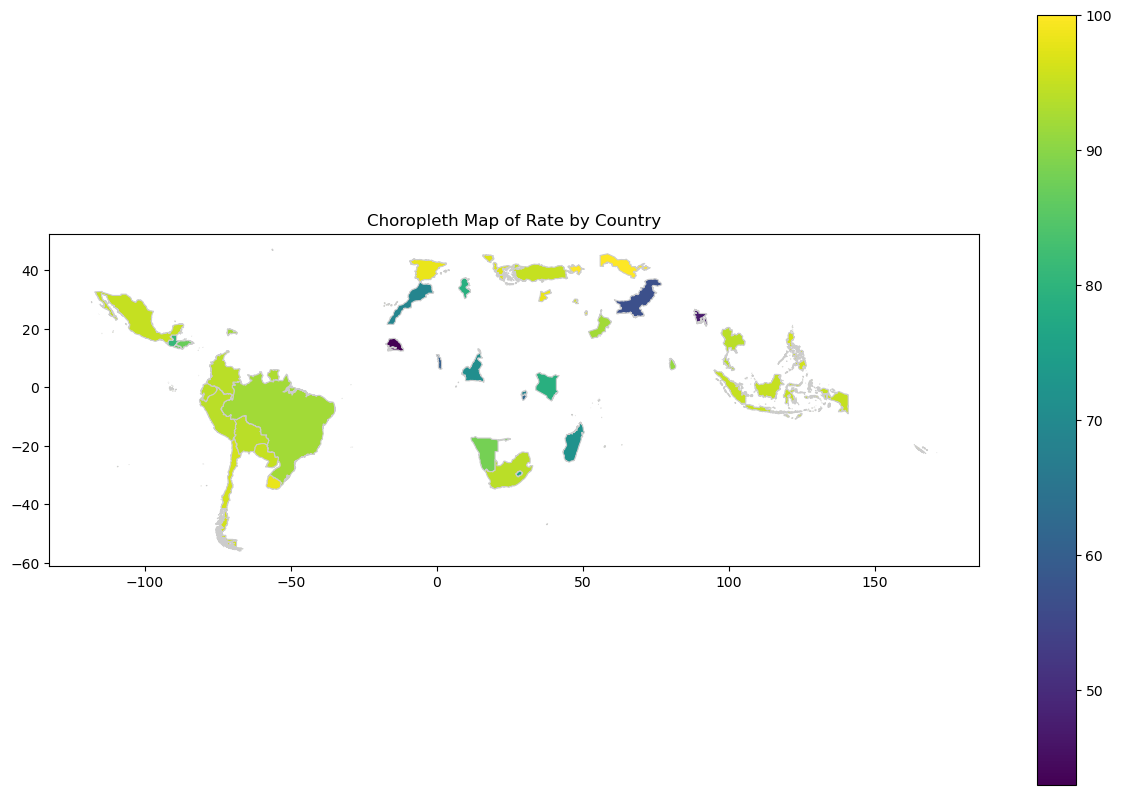

In [10]:
# Merge the GeoDataFrame with combined_df
merged = gdf.merge(combined_df, left_on='ADMIN', right_on='Country')

# Create a choropleth map using the 'Rate' column
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
merged.plot(column='Rate', cmap='viridis', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)

# Add a title
plt.title('Choropleth Map of Rate by Country')

# Show the map
plt.show()

When merging the map data with my dataframe, there seems to be a lot of missing data, so I'm going to fuzzy match the Country geometries with the Country column in my dataframe and create a new gdf to .GeoDataFrame using the matched data and see if it creates a better map.

In [11]:
gdf_names = gdf['ADMIN'].tolist()
combined_df_names = combined_df['Country'].tolist()

# Use fuzzy matching to find the best match for each country
matches = [(country, process.extractOne(country, gdf_names)[0]) for country in combined_df_names]

# Create a dictionary mapping combined_df country names to gdf country names
mapping_dict = {combined_country: gdf_country for combined_country, gdf_country in matches}

# Add the 'geometry' column from gdf to combined_df based on the mapping
combined_df['geometry'] = combined_df['Country'].map(mapping_dict).map(gdf.set_index('ADMIN')['geometry'])

# Now combined_df contains the 'geometry' column
combined_df

,Country,Rate,Year,geometry
0,Arab World,77.0,2014,"MULTIPOLYGON (((53.86305 24.23469, 53.88860 24..."
1,East Asia & Pacific,95.0,2014,"MULTIPOLYGON (((124.35456 -9.36418, 124.34789 ..."
2,East Asia & Pacific (excluding high income),95.0,2014,"MULTIPOLYGON (((124.35456 -9.36418, 124.34789 ..."
3,Europe & Central Asia,99.0,2014,"MULTIPOLYGON (((111.41245 2.38736, 111.41334 2..."
4,Europe & Central Asia (excluding high income),99.0,2014,"POLYGON ((22.55576 10.97897, 22.57705 10.98512..."
...,...,...,...,...
262,Latin America & the Caribbean (IDA & IBRD coun...,95.0,2022,"MULTIPOLYGON (((-73.03393 21.15673, -73.09759 ..."
263,Middle East & North Africa (IDA & IBRD countries),77.0,2022,"MULTIPOLYGON (((125.31275 37.74140, 125.29575 ..."
264,South Asia (IDA & IBRD),74.0,2022,"MULTIPOLYGON (((126.82337 33.55944, 126.83522 ..."
265,Sub-Saharan Africa (IDA & IBRD countries),68.0,2022,"MULTIPOLYGON (((37.86378 -46.94085, 37.83644 -..."


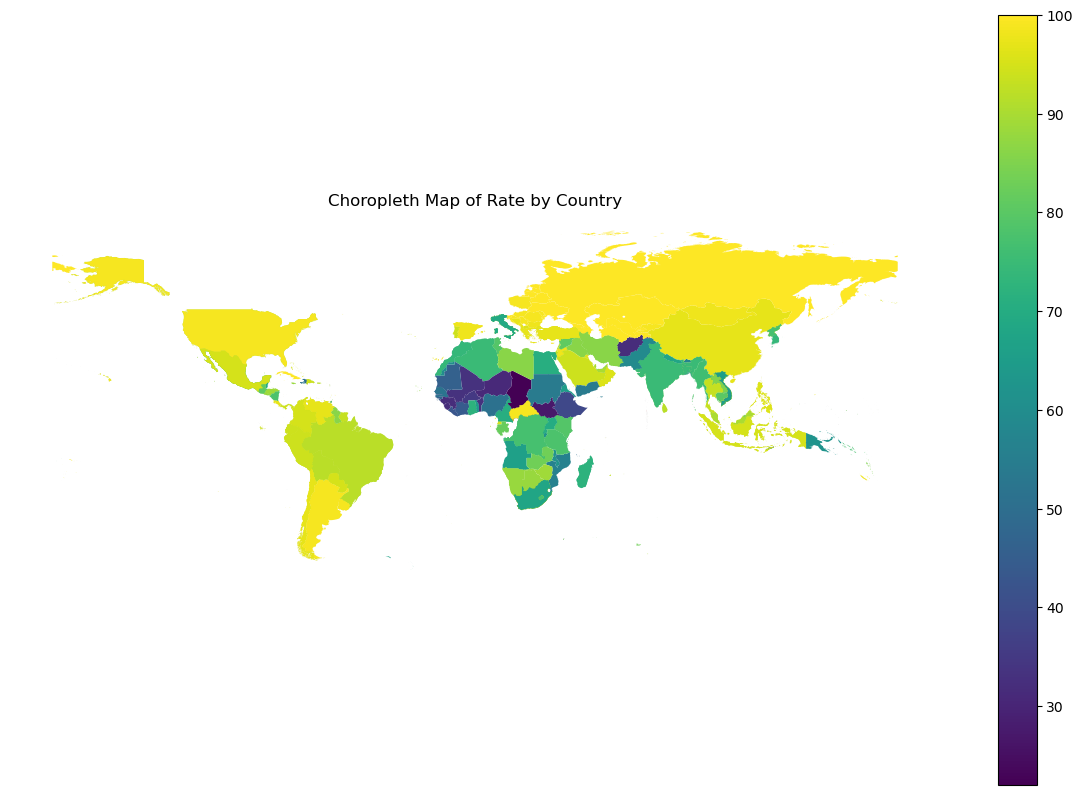

In [12]:
# Create new GeoDataFrame using combined_df and gdf geometries
gdf2 = gpd.GeoDataFrame(combined_df, geometry='geometry')

# Plotting
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
gdf2.plot(column='Rate', cmap='viridis', linewidth=0.8, ax=ax, legend=True)

# Customize the plot as needed
ax.set_title('Choropleth Map of Rate by Country')
ax.set_axis_off()

plt.show()

SO MUCH BETTER! :D

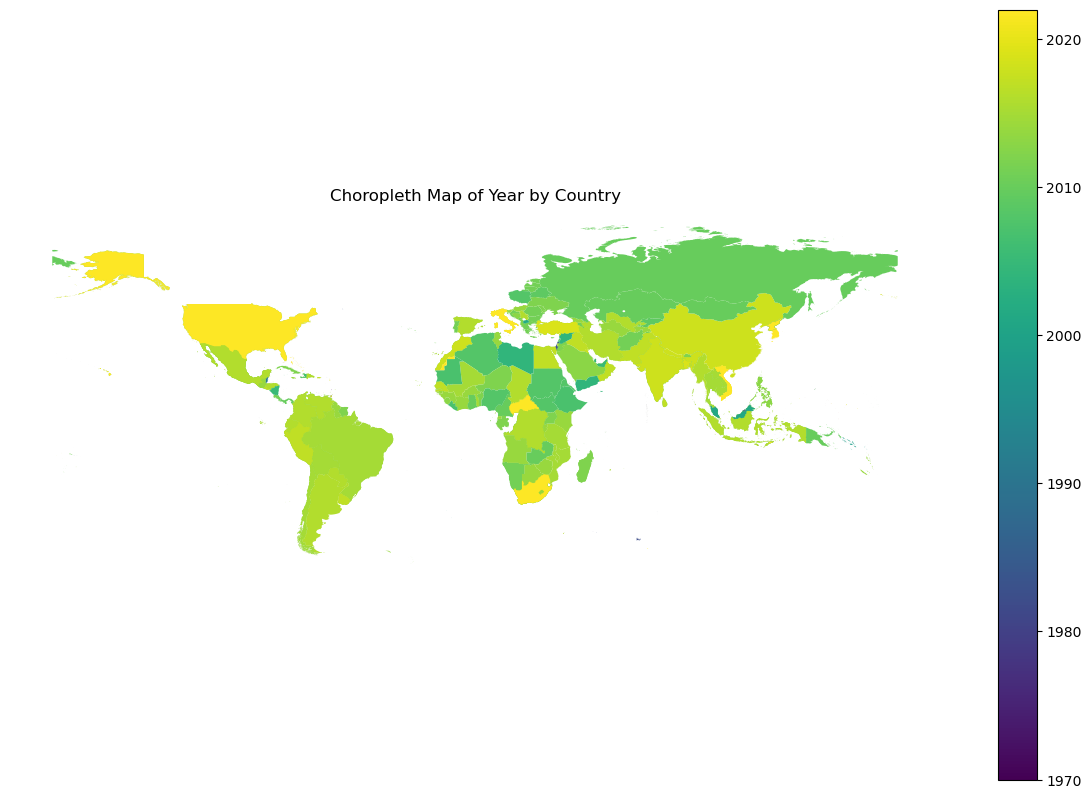

In [13]:
# Create new GeoDataFrame using combined_df and gdf geometries
gdf2 = gpd.GeoDataFrame(combined_df, geometry='geometry')

# Plotting
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
gdf2.plot(column='Year', cmap='viridis', linewidth=0.8, ax=ax, legend=True)

# Customize the plot as needed
ax.set_title('Choropleth Map of Year by Country')
ax.set_axis_off()

plt.show()

Because the gdp geometries also contain Continent and Population data, I'm going to merge the full data frame with my combined_df to get some better visuals to graph.

In [14]:
# Prepare data to merge and fuzzymatch
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Add column for GDP per capita
world = world[(world.pop_est>0) & (world.name!="Antarctica")]
world['gdp_per_cap'] = world.gdp_md_est / world.pop_est
#world.plot(column='gdp_per_cap')

# Create copy of df
combined_df_2 = combined_df.copy()

# Use fuzzy matching to find the best match for each country
matches = [(country, process.extractOne(country, world['name'])[0]) for country in combined_df_2['Country']]

# Create a dictionary mapping combined_df country names to gdf country names
mapping_dict = {combined_country: gdf_country for combined_country, gdf_country in matches}

# Add the 'geometry' column from gdf to combined_df based on the mapping
combined_df_2['gdf_name'] = combined_df_2['Country'].map(mapping_dict)
merged_df = pd.merge(combined_df_2, world, left_on='gdf_name', right_on='name', how='left')

# Now combined_df contains the 'continent', 'pop_est', and 'gdp_per_capita' columns
combined_df_2 = pd.concat([combined_df_2, merged_df[['continent', 'pop_est', 'gdp_per_cap']]], axis=1)

# Drop the intermediate column 'gdf_name' if needed
combined_df_2 = combined_df_2.drop('gdf_name', axis=1)

# Display the resulting DataFrame
combined_df_2

,Country,Rate,Year,geometry,continent,pop_est,gdp_per_cap
0,Arab World,77.0,2014,"MULTIPOLYGON (((53.86305 24.23469, 53.88860 24...",Asia,9770529.0,0.043103
1,East Asia & Pacific,95.0,2014,"MULTIPOLYGON (((124.35456 -9.36418, 124.34789 ...",Oceania,25364307.0,0.055060
2,East Asia & Pacific (excluding high income),95.0,2014,"MULTIPOLYGON (((124.35456 -9.36418, 124.34789 ...",Oceania,25364307.0,0.055060
3,Europe & Central Asia,99.0,2014,"MULTIPOLYGON (((111.41245 2.38736, 111.41334 2...",Asia,31949777.0,0.011414
4,Europe & Central Asia (excluding high income),99.0,2014,"POLYGON ((22.55576 10.97897, 22.57705 10.98512...",Africa,4745185.0,0.000468
...,...,...,...,...,...,...,...
262,Latin America & the Caribbean (IDA & IBRD coun...,95.0,2022,"MULTIPOLYGON (((-73.03393 21.15673, -73.09759 ...",North America,328239523.0,0.065298
263,Middle East & North Africa (IDA & IBRD countries),77.0,2022,"MULTIPOLYGON (((125.31275 37.74140, 125.29575 ...",Africa,58558270.0,0.006001
264,South Asia (IDA & IBRD),74.0,2022,"MULTIPOLYGON (((126.82337 33.55944, 126.83522 ...",Africa,58558270.0,0.006001
265,Sub-Saharan Africa (IDA & IBRD countries),68.0,2022,"MULTIPOLYGON (((37.86378 -46.94085, 37.83644 -...",Africa,58558270.0,0.006001


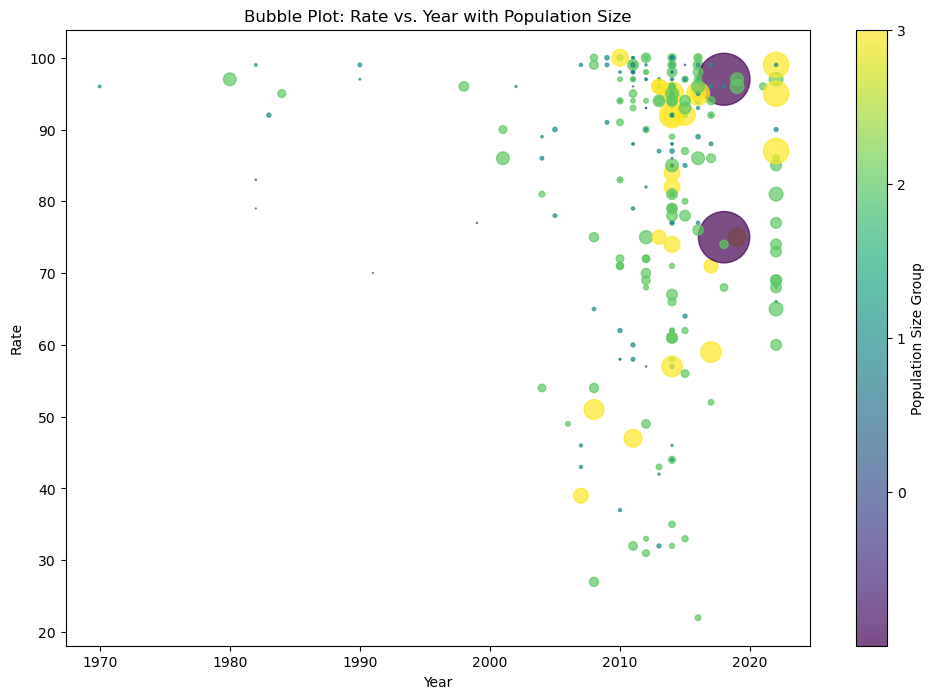

In [15]:
# Create a 'pop_est_group' column based on population size
bins = [0, 10**6, 10**7, 10**8, 10**9]  # Define your population size bins
labels = ['<1M', '1M-10M', '10M-100M', '>100M']
combined_df_2['pop_est_group'] = pd.cut(combined_df_2['pop_est'], bins=bins, labels=labels, right=False)

# Bubble plot
plt.figure(figsize=(12, 8))
scatter = plt.scatter(
    combined_df_2['Year'],
    combined_df_2['Rate'],
    s=combined_df_2['pop_est'] / 1000000,  # Adjust the scaling factor as needed
    c=combined_df_2['pop_est_group'].cat.codes,  # Color by population size group
    cmap='viridis',
    alpha=0.7
)

# Add colorbar
cbar = plt.colorbar(scatter, ticks=range(len(labels)))
cbar.set_label('Population Size Group')

# Set labels and title
plt.xlabel('Year')
plt.ylabel('Rate')
plt.title('Bubble Plot: Rate vs. Year with Population Size')

# Show the plot
plt.show()


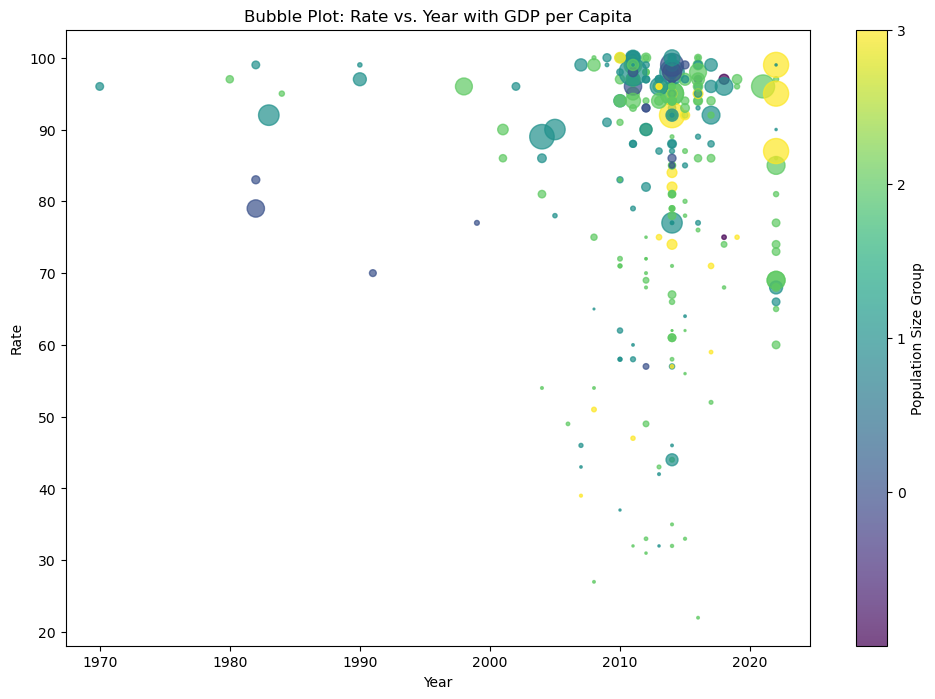

In [16]:
# Convert 'pop_est_group' to numerical codes
combined_df_2['pop_est_group_code'] = combined_df_2['pop_est_group'].cat.codes

# Bubble plot with size based on 'gdp_per_cap'
plt.figure(figsize=(12, 8))
scatter = plt.scatter(
    combined_df_2['Year'],
    combined_df_2['Rate'],
    s=combined_df_2['gdp_per_cap'] * 5000,  # Adjust the scaling factor as needed
    c=combined_df_2['pop_est_group_code'],  # Color by numerical code of population size group
    cmap='viridis',
    alpha=0.7
)

# Add colorbar
cbar = plt.colorbar(scatter, ticks=range(len(combined_df_2['pop_est_group'].unique())))
cbar.set_label('Population Size Group')

# Set labels and title
plt.xlabel('Year')
plt.ylabel('Rate')
plt.title('Bubble Plot: Rate vs. Year with GDP per Capita')

# Show the plot
plt.show()

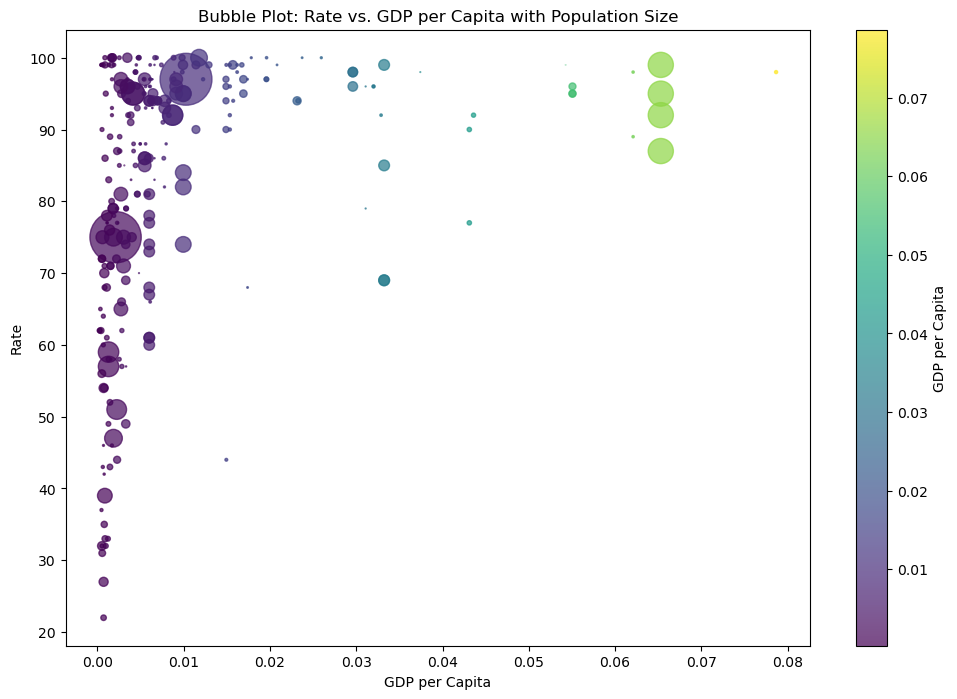

In [17]:
# Bubble plot with size based on 'pop_est' and color based on 'gdp_per_cap'
plt.figure(figsize=(12, 8))
scatter = plt.scatter(
    combined_df_2['gdp_per_cap'],
    combined_df_2['Rate'],
    s=combined_df_2['pop_est'] / 1000000,  # Adjust the scaling factor as needed
    c=combined_df_2['gdp_per_cap'],  # Color by GDP per Capita
    cmap='viridis',
    alpha=0.7
)

# Add colorbar
cbar = plt.colorbar(scatter)
cbar.set_label('GDP per Capita')

# Set labels and title
plt.xlabel('GDP per Capita')
plt.ylabel('Rate')
plt.title('Bubble Plot: Rate vs. GDP per Capita with Population Size')

# Show the plot
plt.show()

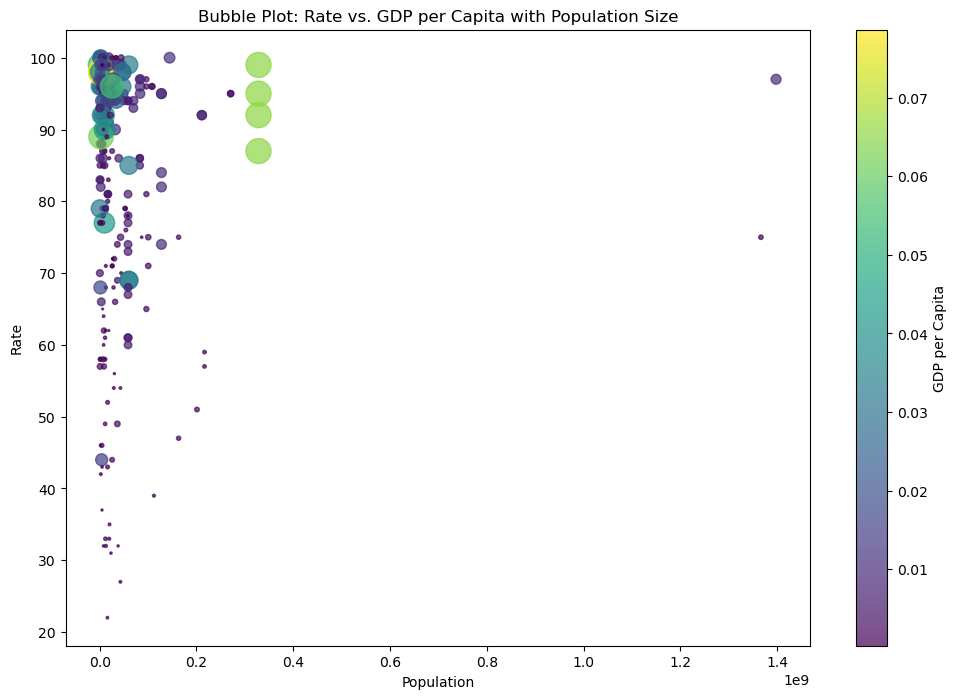

In [18]:
# Bubble plot with size based on 'pop_est' and color based on 'gdp_per_cap'
plt.figure(figsize=(12, 8))
scatter = plt.scatter(
    combined_df_2['pop_est'],
    combined_df_2['Rate'],
    s=combined_df_2['gdp_per_cap'] * 5000,  # Adjust the scaling factor as needed
    c=combined_df_2['gdp_per_cap'],  # Color by GDP per Capita
    cmap='viridis',
    alpha=0.7
)

# Add colorbar
cbar = plt.colorbar(scatter)
cbar.set_label('GDP per Capita')

# Set labels and title
plt.xlabel('Population')
plt.ylabel('Rate')
plt.title('Bubble Plot: Rate vs. GDP per Capita with Population Size')

# Show the plot
plt.show()

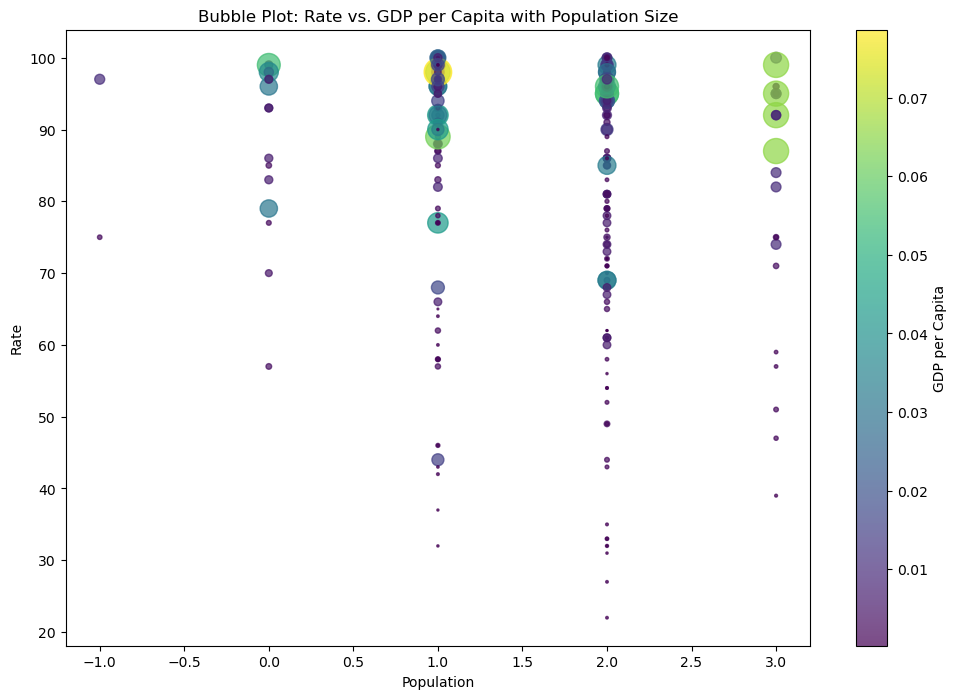

In [19]:
# Convert 'pop_est_group' to numerical codes
combined_df_2['pop_est_group_code'] = combined_df_2['pop_est_group'].cat.codes

# Bubble plot with size based on 'pop_est' and color based on 'gdp_per_cap'
plt.figure(figsize=(12, 8))
scatter = plt.scatter(
    combined_df_2['pop_est_group_code'],
    combined_df_2['Rate'],
    s=combined_df_2['gdp_per_cap'] * 5000,  # Adjust the scaling factor as needed
    c=combined_df_2['gdp_per_cap'],  # Color by GDP per Capita
    cmap='viridis',
    alpha=0.7
)

# Add colorbar
cbar = plt.colorbar(scatter)
cbar.set_label('GDP per Capita')

# Set labels and title
plt.xlabel('Population')
plt.ylabel('Rate')
plt.title('Bubble Plot: Rate vs. GDP per Capita with Population Size')

# Show the plot
plt.show()

In [20]:
print(combined_df_2.dtypes)

Country                 object
Rate                   float64
Year                     int64
geometry              geometry
continent               object
pop_est                float64
gdp_per_cap            float64
pop_est_group         category
pop_est_group_code        int8
dtype: object


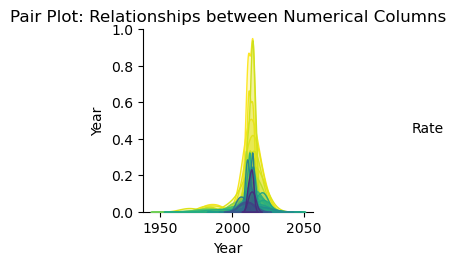

In [21]:
# Visualization 4: Pair Plot (Relationships between numerical columns)

# Replace infinity values with NaN to avoid FutureWarnings #still occurs
combined_df.replace([np.inf, -np.inf], np.nan, inplace=True)

combined_df_pair_plot = combined_df[['Rate', 'Year']].dropna()

sns.pairplot(combined_df_pair_plot, hue='Rate', palette='viridis')
plt.suptitle('Pair Plot: Relationships between Numerical Columns', y=1.02)
plt.show()

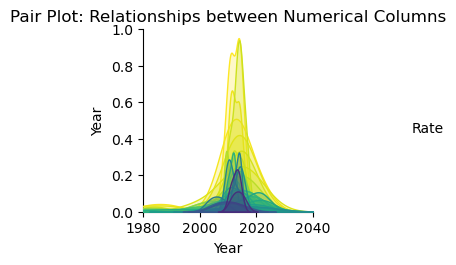

In [22]:
# Visualization 4: Pair Plot (Relationships between numerical columns)

# Replace infinity values with NaN to avoid FutureWarnings
combined_df.replace([np.inf, -np.inf], np.nan, inplace=True)

combined_df_pair_plot = combined_df[['Rate', 'Year']].dropna()

# Set the desired x-axis range
x_range = (1980, 2040)

# Pair plot with limited x-axis range
sns.pairplot(combined_df_pair_plot, hue='Rate', palette='viridis')
plt.suptitle('Pair Plot: Relationships between Numerical Columns', y=1.02)
plt.xlim(x_range)  # Set x-axis range
plt.show()


In [23]:
# Visualization 1: Box Plot (Rate Distribution by Country)
# Convert 'Country' to categorical data and assign numerical codes
combined_df_2['Country'] = combined_df['Country'].astype('category')
combined_df_2['Country_Code'] = combined_df['Country'].cat.codes

plt.figure(figsize=(12, 6))
sns.boxplot(x='Country_Code', y='Rate', data=combined_df)
plt.title('Box Plot: Rate Distribution by Country')
plt.xticks(ticks=range(len(combined_df['Country'].unique())), labels=combined_df['Country'].unique(), rotation=45, ha='right')
plt.show()

AttributeError: Can only use .cat accessor with a 'category' dtype

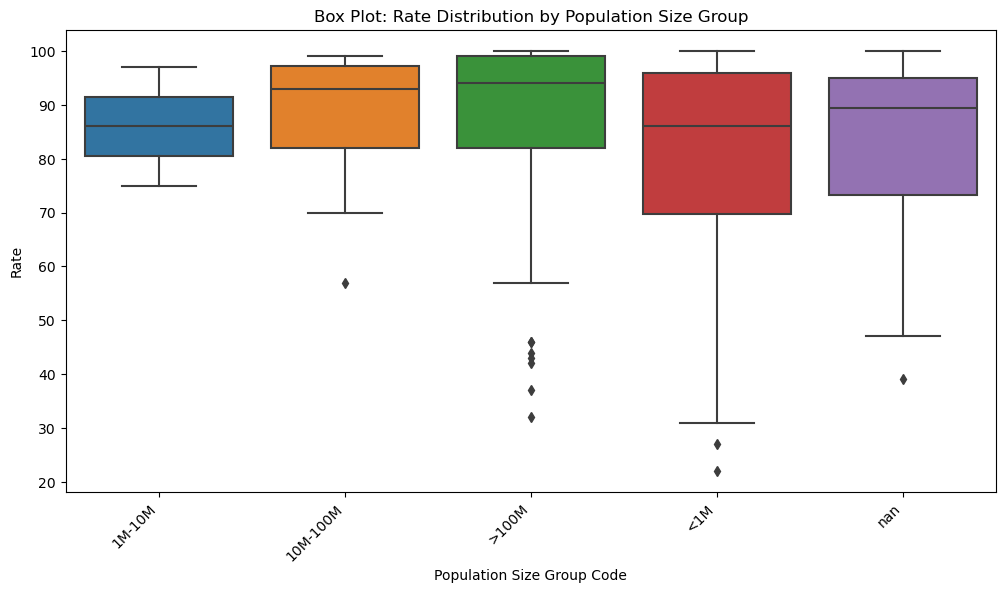

In [24]:
# Visualization 1: Box Plot (Rate Distribution by Population Size Group)
plt.figure(figsize=(12, 6))
sns.boxplot(x='pop_est_group_code', y='Rate', data=combined_df_2)
plt.title('Box Plot: Rate Distribution by Population Size Group')
plt.xticks(ticks=range(len(combined_df_2['pop_est_group'].unique())),
           labels=combined_df_2['pop_est_group'].unique(), rotation=45, ha='right')
plt.xlabel('Population Size Group Code')
plt.ylabel('Rate')
plt.show()

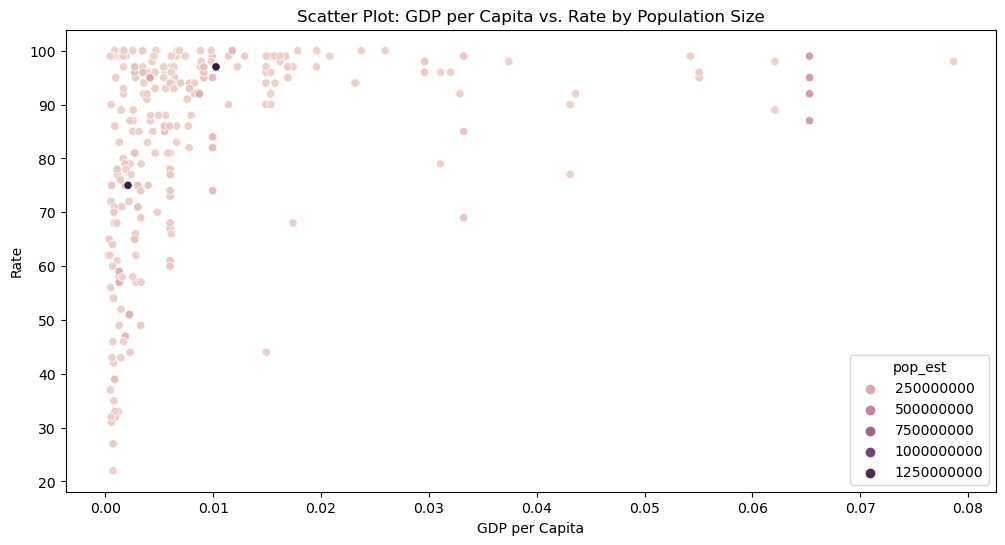

In [25]:
# Visualization 3: Scatter Plot (GDP per Capita vs. Rate)
plt.figure(figsize=(12, 6))
sns.scatterplot(x='gdp_per_cap', y='Rate', hue='pop_est', data=combined_df_2)
plt.title('Scatter Plot: GDP per Capita vs. Rate by Population Size')
plt.xlabel('GDP per Capita')
plt.ylabel('Rate')
plt.show()

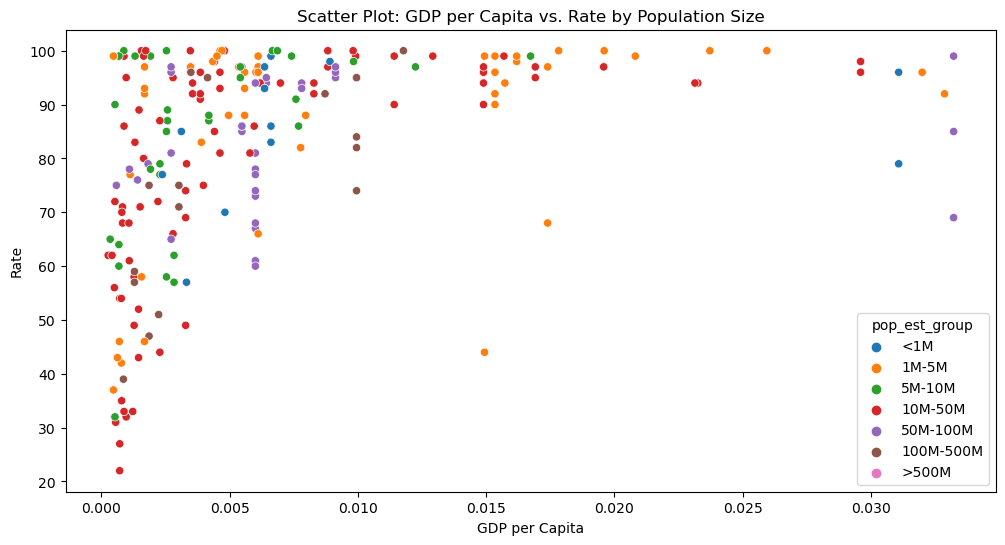

In [26]:
# Create more population size groups
bins = [0, 10**6, 5 * 10**6, 10**7, 5 * 10**7, 10**8, 5 * 10**8, 10**9]
labels = ['<1M', '1M-5M', '5M-10M', '10M-50M', '50M-100M', '100M-500M', '>500M']
combined_df_2['pop_est_group'] = pd.cut(combined_df_2['pop_est'], bins=bins, labels=labels, right=False)

# Visualization 3: Scatter Plot (GDP per Capita vs. Rate)
plt.figure(figsize=(12, 6))

# Filter data to exclude outliers (gdp_per_cap > 0.05)
filtered_df = combined_df_2[combined_df_2['gdp_per_cap'] <= 0.035]

sns.scatterplot(x='gdp_per_cap', y='Rate', hue='pop_est_group', data=filtered_df)
plt.title('Scatter Plot: GDP per Capita vs. Rate by Population Size')
plt.xlabel('GDP per Capita')
plt.ylabel('Rate')
plt.show()

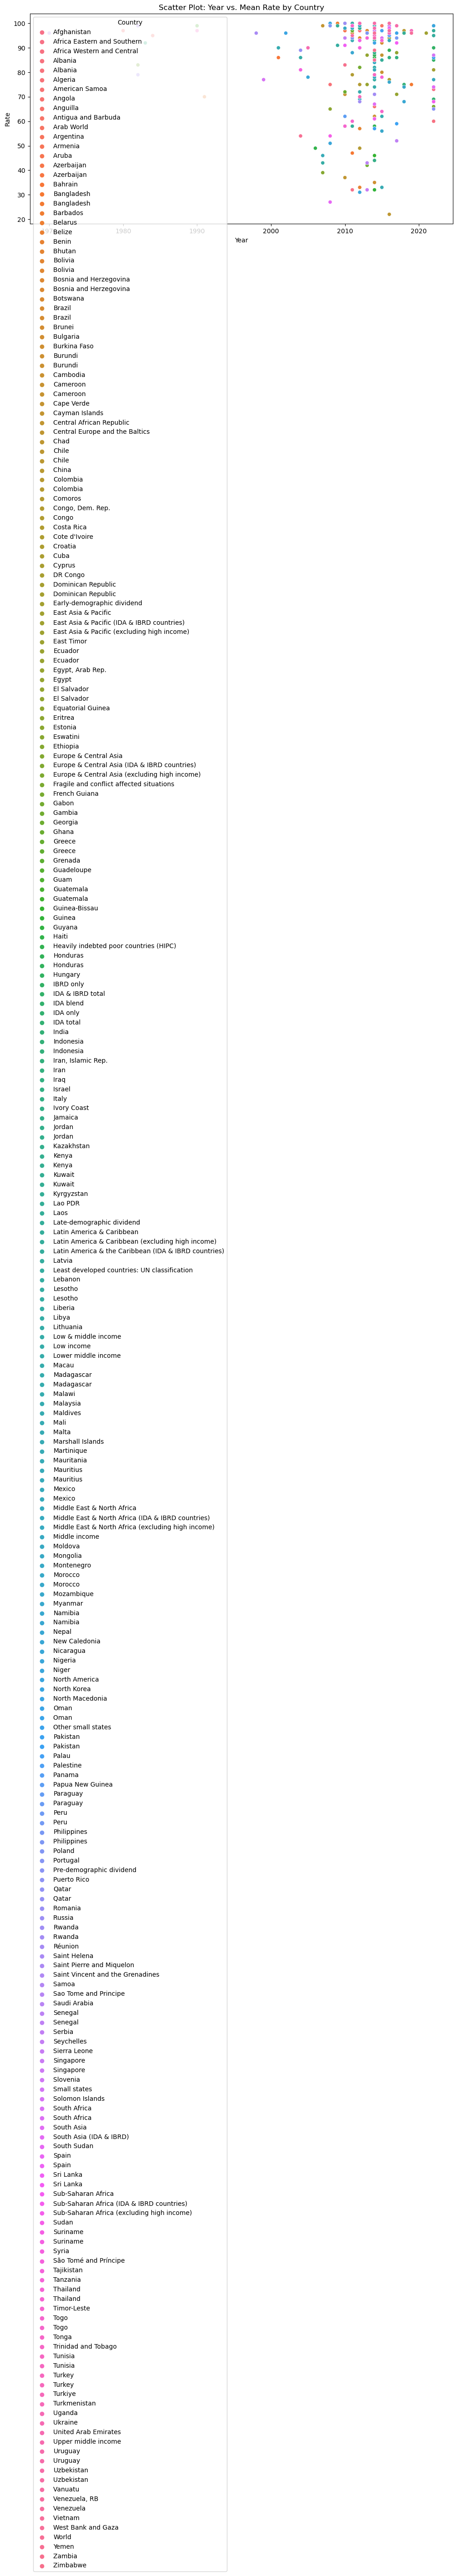

In [27]:
# Aggregate data by country and year
agg_data = combined_df_2.groupby(['Country', 'Year']).agg({'Rate': 'mean'}).reset_index()

# Plotting aggregated data
plt.figure(figsize=(12, 6))
sns.scatterplot(x='Year', y='Rate', hue='Country', data=agg_data)
plt.title('Scatter Plot: Year vs. Mean Rate by Country')
plt.show()

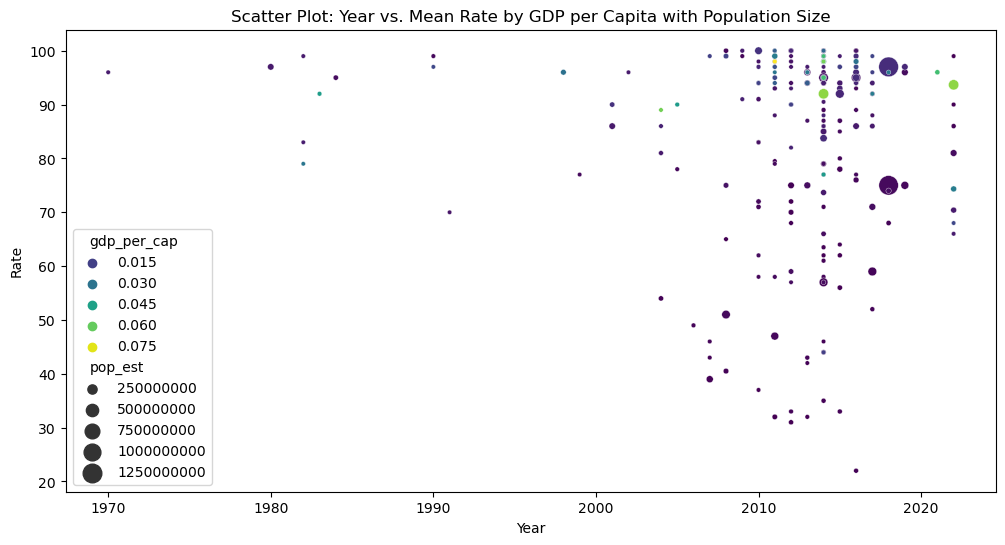

In [28]:
# Aggregate data by gdp_per_cap and year, including population size for size of dots
agg_data_gdp_pop = combined_df_2.groupby(['gdp_per_cap', 'Year']).agg({'Rate': 'mean', 'pop_est': 'mean'}).reset_index()

# Plotting aggregated data
plt.figure(figsize=(12, 6))
sns.scatterplot(x='Year', y='Rate', hue='gdp_per_cap', size='pop_est', sizes=(10, 200), data=agg_data_gdp_pop, palette='viridis')
plt.title('Scatter Plot: Year vs. Mean Rate by GDP per Capita with Population Size')
plt.show()

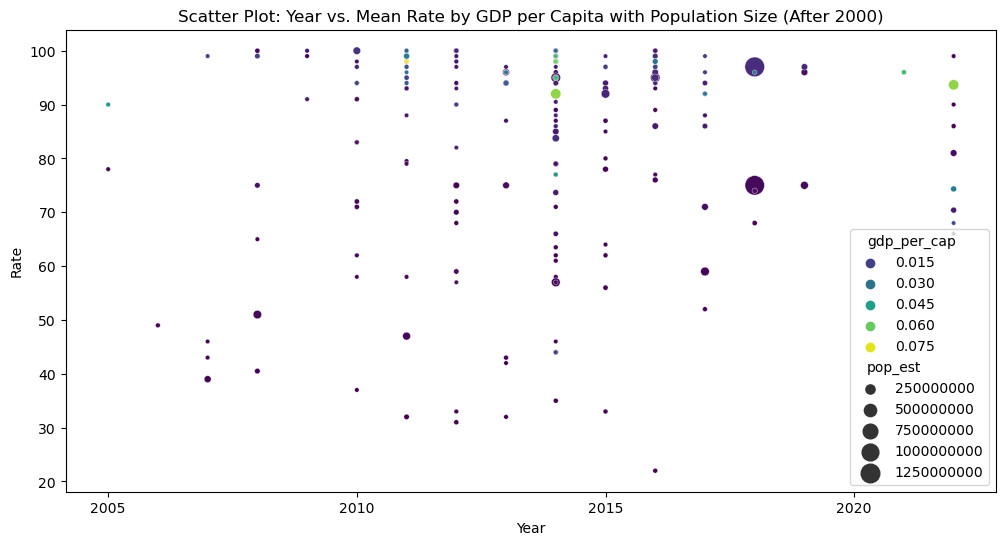

In [29]:
# Filter data for years after 2000
filtered_data = combined_df_2[combined_df_2['Year'] > 2004]

# Aggregate data by gdp_per_cap and year, including population size for the size of dots
agg_data_gdp_pop = filtered_data.groupby(['gdp_per_cap', 'Year']).agg({'Rate': 'mean', 'pop_est': 'mean'}).reset_index()

# Set the x-axis ticks to show every five years
x_ticks = range(filtered_data['Year'].min(), filtered_data['Year'].max() + 1, 5)

# Plotting aggregated data
plt.figure(figsize=(12, 6))
sns.scatterplot(x='Year', y='Rate', hue='gdp_per_cap', size='pop_est', sizes=(10, 200), data=agg_data_gdp_pop, palette='viridis')
plt.title('Scatter Plot: Year vs. Mean Rate by GDP per Capita with Population Size (After 2000)')
plt.xticks(ticks=x_ticks)
plt.show()

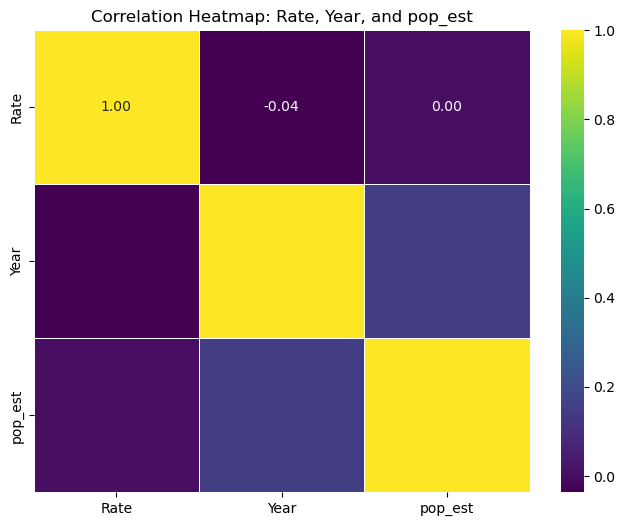

In [30]:
# Visualization 5: Correlation Heatmap
import seaborn as sns
import matplotlib.pyplot as plt

# Select relevant columns for correlation
correlation_columns = ['Rate', 'Year', 'pop_est']

# Create a subset of the DataFrame with the selected columns
correlation_subset = combined_df_2[correlation_columns]

# Calculate the correlation matrix
correlation_matrix = correlation_subset.corr()

# Set up the matplotlib figure
plt.figure(figsize=(8, 6))

# Create a heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='viridis', fmt=".2f", linewidths=.5)

# Set the title
plt.title('Correlation Heatmap: Rate, Year, and pop_est')

# Show the plot
plt.show()


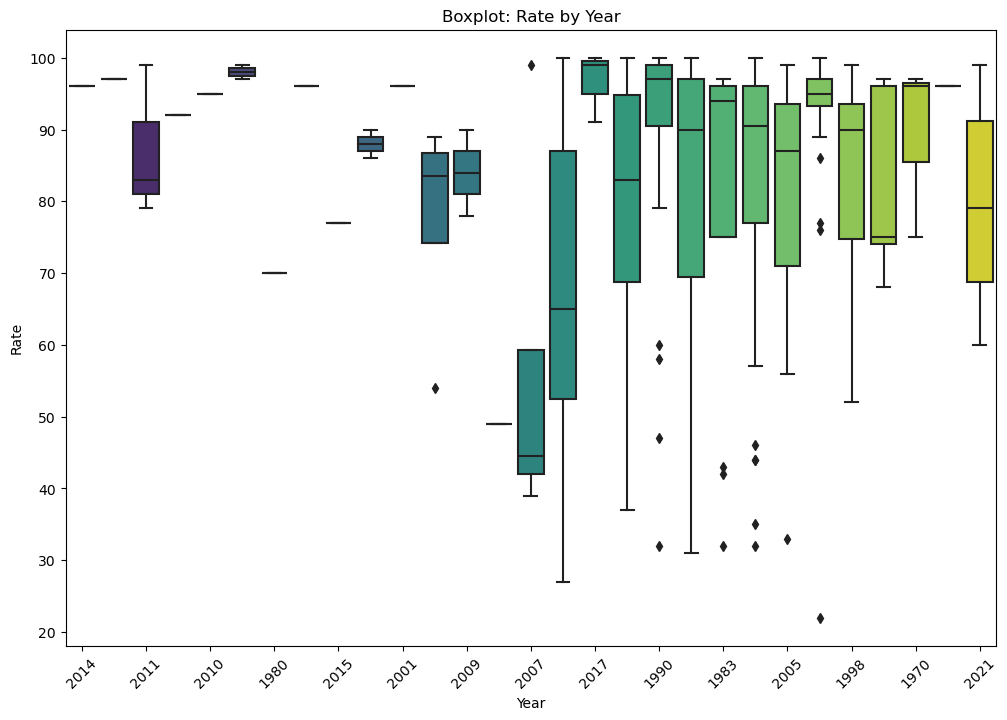

In [31]:
# Boxplot
plt.figure(figsize=(12, 8))
sns.boxplot(x='Year', y='Rate', data=combined_df, palette='viridis')
plt.title('Boxplot: Rate by Year')
plt.xlabel('Year')
plt.ylabel('Rate')

# Set ticks for every 10 years
unique_years = combined_df['Year'].unique()
tick_positions = range(0, len(unique_years), len(unique_years)//10)
tick_labels = unique_years[tick_positions]
plt.xticks(tick_positions, tick_labels, rotation=45)

plt.show()

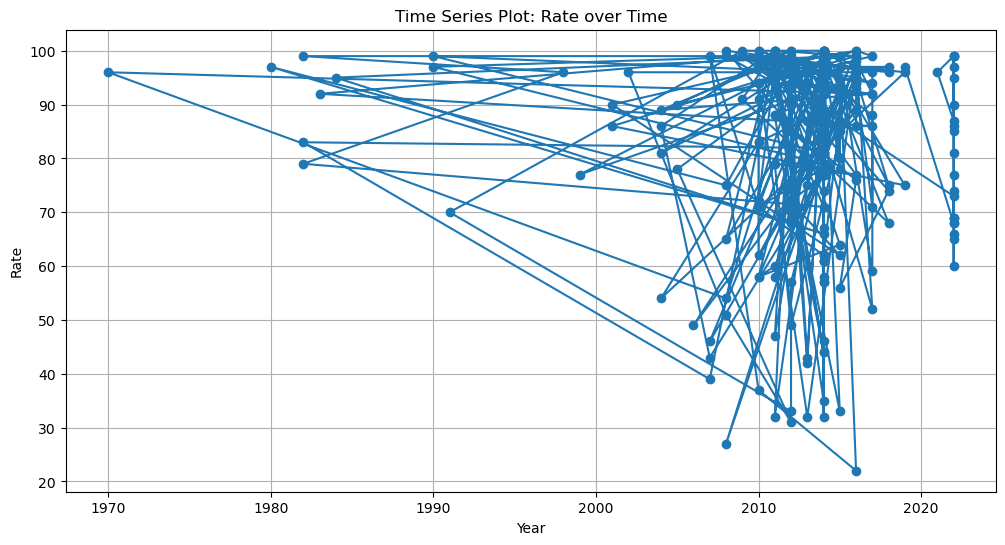

In [32]:
import matplotlib.pyplot as plt

# Assuming 'Year' is the column containing the time information
# and 'Rate' is the numerical variable you want to visualize
plt.figure(figsize=(12, 6))
plt.plot(combined_df['Year'], combined_df['Rate'], marker='o', linestyle='-')

plt.title('Time Series Plot: Rate over Time')
plt.xlabel('Year')
plt.ylabel('Rate')
plt.grid(True)
plt.show()


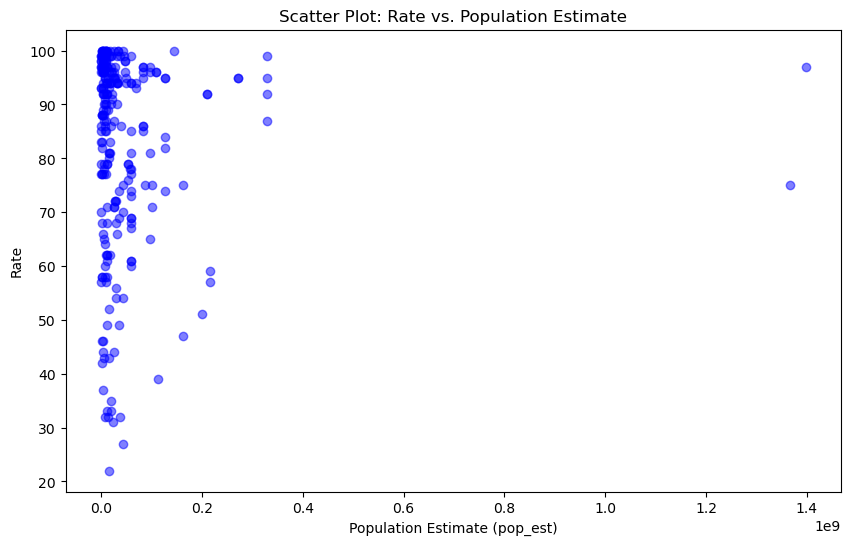

In [33]:
import matplotlib.pyplot as plt

# Scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(combined_df_2['pop_est'], combined_df_2['Rate'], alpha=0.5, color='blue')

# Set labels and title
plt.xlabel('Population Estimate (pop_est)')
plt.ylabel('Rate')
plt.title('Scatter Plot: Rate vs. Population Estimate')

# Show the plot
plt.show()

### Summary:

This project involved merging and storing three datasets related to adult literacy rates from csv files, website data, and API data into a SQLite database, followed by creating visualizations to demonstrate the cleansed data. The project also involved fuzzy matching to address missing data when merging geographical information for creating a choropleth map.

In terms of merging the geographical data with the main DataFrame, fuzzy matching was employed to find the best match for each country between the two datasets, significantly improving the resulting choropleth map. I got a little overzealous with my visualizations, trying to cover a wide range, but was unable to push some of them to their full potential. They include some (really really cool) choropleth maps, bubble plots, pair plots, box plots, scatter plots, and time series plots. These visualizations aimed to reveal insights into the relationships between adult literacy rates rates, geographical data, GDP per capita, and population size. The unfinished visuals also included a correlation heatmap and a boxplot illustrating the distribution of literacy rates over the years.

Throughout the project, I learned many, many things. The significance of data cleaning and preprocessing was evident, especially when dealing with multiple datasets that required merging. Fuzzy matching proved to be an insanely valuable technique for handling missing or mismatched data, greatly enhancing the accuracy of the geographical representations. Additionally, the power of visualizations in uncovering patterns and trends in complex datasets became apparent. Various libraries like Matplotlib, Seaborn, and GeoPandas were employed to create meaningful and insightful visual representations.

From an ethical standpoint, the project highlights the importance of transparency in data cleaning processes. Fuzzy matching, while a useful technique, involves subjective decisions that may introduce biases. It is crucial to document and communicate the steps taken during data cleansing to ensure the reproducibility of results and allow for scrutiny. Furthermore, the project's focus on literacy rates and its correlation with GDP per capita raises ethical considerations related to global inequalities. Analyzing and visualizing such data should be done with a sensitivity to potential biases and a commitment to promoting fairness and inclusivity.

In conclusion, the project demonstrated the intricacies of merging, cleaning, and visualizing diverse datasets. The use of fuzzy matching and various visualization techniques contributed to a more comprehensive understanding of the data. Ethical considerations underscored the need for transparency and fairness in data cleansing processes, especially when dealing with topics that have societal implications.